### Enterprise software documentation: workbook

###### Compares public facing documentation websites of consumer enterprise software companies on the Fortune 500 2015 list as well as Atlassian and a handful of single-product competetors.
- This initial exploration looks at average article length for the docs sets, as well as the range of different article lengths a docs set has (article length distributions)
- Games, entertainment and non-consumer docs excluded
- Doc set and article size distributions are varied across the different companies and could be used as predictor of software complexity or other
- No clear candidates for a regression analysis in the docs data yet (but some small trends for Alexa web traffic rank)
- Cluster graph on distribution parameters seemed to identify 4 docs set groups.

###### Workbook steps:
    1. Read in docs sitemaps
        * a) Notes on sitemaps
        * b) Check requests status
        * c) Remove bad requests
        * d) Remove word counts < 50
	* e) Number of html pages in each doc site
	* f) Graph total docs pages
    2. Distributions of article length
        * a) Plot doc set article length distributions
        * b) Descriptive statistics of article word count
        * c) Test distribution normalility/ pairwise - not finished   
    3. Regression tests
        * a) Load company data add docs metrics        
	* b) Scatter plots
        * c) RANSAC regression analysis
        * d) Graph regression: shareprice & web traffic
	* e) Graph regression: article length & web traffic
    4. Cluster analysis 
        * a) Plot clusters in 2d (mean, skew)
        * b) 3D cluster plot
        * c) Article length distribution clusters
    5. Preliminary results
        * Regression analysis of Alexa web traffic rank for docs domain
	* KMeans clusters for article length distributions
        
##### Next steps
    1. Pull in article text with docs_text_scrape.py for NLP analysis
    2. Additional steps on company/docs research and cleaning sitemap data - specifically, more qualitative metrics around of type of software & docs sets from NLP analyses
    3. To what extent are documentation factors associated with company profitability (if at all)?
    4. Predict revenue/shareprice for non-listed companies based on docs factors?
    5. Create model of docs style for software types
    5. Decision tree for legacy management/ docs design type
    
##### Areas to improve:
    * Indexing DataFrame's - got stuck on finding less manual ways to concat, plot etc
    * Cleaning up HTML data other than status, seperate content indexes (landing pages) from articles 

##### Decision tree for legacy management or docs structure changes
Notes for an additional analysis not included in this project
* Use Google analytics intergration with SEO spider to plot traffic density each CAC page & directory
* Develop a traffic threshold that could guide us in legacy management - I.e. spaces below a certain threshold can be archieved as PDF files
        

##### Install python libraries

In [3]:
import numpy as np
from scipy import stats
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import sklearn.linear_model
import sklearn.cluster
import sklearn.datasets
from mpl_toolkits.mplot3d import Axes3D

### 1. Read in docs sitemaps
**a) Notes on sitemaps**
- Read sitemaps for Fortune 500 consumer enterprise software companies with proportion of software revenue >75% + Atlassian and some smaller single product companies
- Maps made with web crawler GUI 'Screaming frog SEO' https://www.screamingfrog.co.uk/
- Easy to monitor & control (pause, save) massive website crawls (Atlassian CAC took 12 hours +)
- In the terminal/bash command window type 'defaults write uk.co.screamingfrog.seo.spider Memory 8g' to allocate lots of memory while running big crawls
- Filter map for HTML only (can filter for pdf later) and export as .csv file

List of sitemap urls & csv files
- Games, entertainment docs excluded
- Also excluded are docs sets behind a login
- Autodesk has non-english language directories sitting on the same level as enmglish content which will need to be removed
- **Note** Read-ins take two runs on initial load for some reason

In [6]:
# Fortune 500 top 5 enterprise software companies sw revenue >75%
smap01 = pd.read_csv('data/docsurls_microsoft.csv') # [√] https://docs.microsoft.com/en-us/
smap02 = pd.read_csv('data/docsurls_oracle.csv') # [√] https://docs.oracle.com/en/
smap03 = pd.read_csv('data/docsurls_salesforce.csv') # [√] https://help.salesforce.com/
smap04 = pd.read_csv('data/docsurls_symantec.csv') # [√] https://support.symantec.com/en_US/
smap05a = pd.read_csv('data/docsurls_adobe_p1.csv') # [√] https://docs.adobe.com/
smap05b = pd.read_csv('data/docsurls_adobe_p2.csv')
afrms = [smap05a,smap05b] 
smap06 = pd.read_csv('data/docsurls_intuit.csv') # [√] https://community.intuit.com/ or https://developer.intuit.com/docs/
smap07 = pd.read_csv('data/docsurls_CA.csv') # [BTW] http://www.ca.com/us/support/ca-support-online/
#smap08 = pd.read_csv('data/docsurls_teradata.csv') # [BTW] http://www.info.teradata.com/
smap09a = pd.read_csv('data/docsurls_autodesk_p1.csv') # [] https://knowledge.autodesk.com/support
smap09b = pd.read_csv('data/docsurls_autodesk_p2.csv')
smap09c = pd.read_csv('data/docsurls_autodesk_p3.csv')
a9frms = [smap09a,smap09b,smap09c] 
smap10 = pd.read_csv('data/docsurls_synopsis.csv') # [BTW] http://www.synopsys.com/Support/
smap11 = pd.read_csv('data/docsurls_akamai.csv') # [BTW] https://developer.akamai.com/
smap12 = pd.read_csv('data/docsurls_nuance.csv') # [BTW] http://www.nuance.com/support/

In [7]:
# Atlassian and single-product competitors
smap13p1 = pd.read_csv('data/docsurls_atlassian_p1.csv') # [√] https://confluence.atlassian.com/
smap13p2 = pd.read_csv('data/docsurls_atlassian_p2.csv') # [√] https://confluence.atlassian.com/
smap13p3 = pd.read_csv('data/docsurls_atlassian_p3.csv') # [√] https://confluence.atlassian.com/
smap13p4 = pd.read_csv('data/docsurls_atlassian_p4.csv') # [√] https://confluence.atlassian.com/
frms = [smap13p1,smap13p2,smap13p3,smap13p4] # [√] https://confluence.atlassian.com/
smap14 = pd.read_csv('data/docsurls_trello.csv') # [√] http://help.trello.com/
smap15 = pd.read_csv('data/docsurls_slack.csv') # [√] https://get.slack.help/
smap16 = pd.read_csv('data/docsurls_github.csv') # [√] https://help.github.com/ or https://guides.github.com/
smap17 = pd.read_csv('data/docsurls_dropbox.csv') # [√] https://www.dropbox.com/help
#smap18 = pd.read_csv('data/docsurls_atlassianDAC.csv') # [] https://developer.atlassian.com/

In [8]:
smap05 = pd.concat(afrms)
smap09 = pd.concat(a9frms)
smap13 = pd.concat(frms)

In [9]:
smap_idx = [smap01,smap02,smap03,smap04,smap05,smap06,smap07,smap09,smap10,smap11,smap12,smap13,smap14,
            smap15,smap16,smap17]
clen = len(smap_idx)
print 'Number of company docs:', clen

Number of company docs: 16


**b) Check requests status**
- 200, 302 vs other
- Look at request status and remove bad requests from docs sets

In [10]:
tmpcnt = {}
tmpok = {}
tmpbad = {}
for k in range(0,clen):
    tmpsmp = smap_idx[k]
    c = Counter(tmpsmp['Status'])
    tmpcnt[k] = len(tmpsmp['Status'])
    tmpok[k] = c['OK'] or c['Found']
    tmpbad[k] = tmpcnt[k]-tmpok[k]
    #print tmpok[k],'/',(tmpcnt[k]) # <------ look at ok/all ratios

* Plot status 

# ======= Status codes =======#


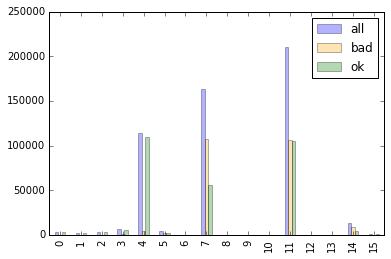

In [11]:
status = pd.DataFrame({'all':tmpcnt,'ok':tmpok,'bad':tmpbad})
print '# ======= Status codes =======#'
fig = status.plot.bar(color={'Orange','Green', 'Blue'}, alpha=0.3)

**c) Remove bad requests**

In [12]:
for r in range(1,clen):
    tmp = smap_idx[r]
    tmpidx = tmp[tmp['Status']=='OK']
    smap_idx[r] = tmpidx

** d) Remove word counts < 50 **

In [13]:
for p in range(1,clen):
    tmp = smap_idx[p]
    tmpidx = tmp[tmp['Word Count']>51]
    smap_idx[p] = tmpidx

**e) Number of html pages in each doc site**

How many html files are there? 
- Get the relative sizes of each docs set
- Clean up later by:
    - Check full product suite is represented by counting/including other docs/support subdomains for the company
    - Removing html files with paragraph text less than the average sentence length
- As a proportion of numer of products
- As a measure of the software or the docs 'complexity'?

In [14]:
slen = 0
savelen = {}
#print 'Number of html pages in each doc site: '
for n in range(0,len(smap_idx)):
    slen = slen + len(smap_idx[n])
    savelen[n] = len(smap_idx[n])
pages = {'pages':savelen}
docpagecnt = pd.DataFrame(pages)
#print docpagecnt['pages']
print 'Total html pages counted: ',slen

Total html pages counted:  244178


** f) Graph total docs pages**

Number of companies: 16


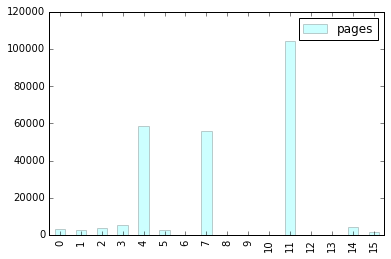

In [15]:
docpagecnt.plot.bar(color='cyan', alpha=0.2)
print 'Number of companies:', len(smap_idx)

### 2. Distributions of article length
Look at how article length is distributed - are a companies docs all around the same length or is article length more variable (more widely distributed)?

In [16]:
wc = {}
gwc = {}
xtmp = {}
bins=50
#cols = ['Black','Purple','Blue','Cyan','Green','Yellow','Orange','Red']
for w in range(0,len(smap_idx)):
    tmp = smap_idx[w]
    xtmp[w] = np.array(tmp['Word Count'])
    #color = cols[w]    
    gwc[w] = sum(xtmp[w])
    wc[w] = tmp['Word Count'].mean()
print 'Total word count for the websites: ', gwc

Total word count for the websites:  {0: 2119772, 1: 1433127, 2: 2179135, 3: 4743648, 4: 33481296, 5: 7902193, 6: 51786, 7: 23669533.0, 8: 214956, 9: 184907, 10: 68113, 11: 138113580, 12: 54805, 13: 201221, 14: 1459792, 15: 1300041}


** a) Plot doc set article length distributions**

In [17]:
cols = np.array(['#E50004','#E22B00','#DF5B00','#DD8900','#DAB700','#CDD800','#9CD500','#6DD300','#3FD000','#12CE00'
              ,'#00CB19','#00C944','#00C66E','#00C496','#00C1BE','#0098BF'])
c = cols

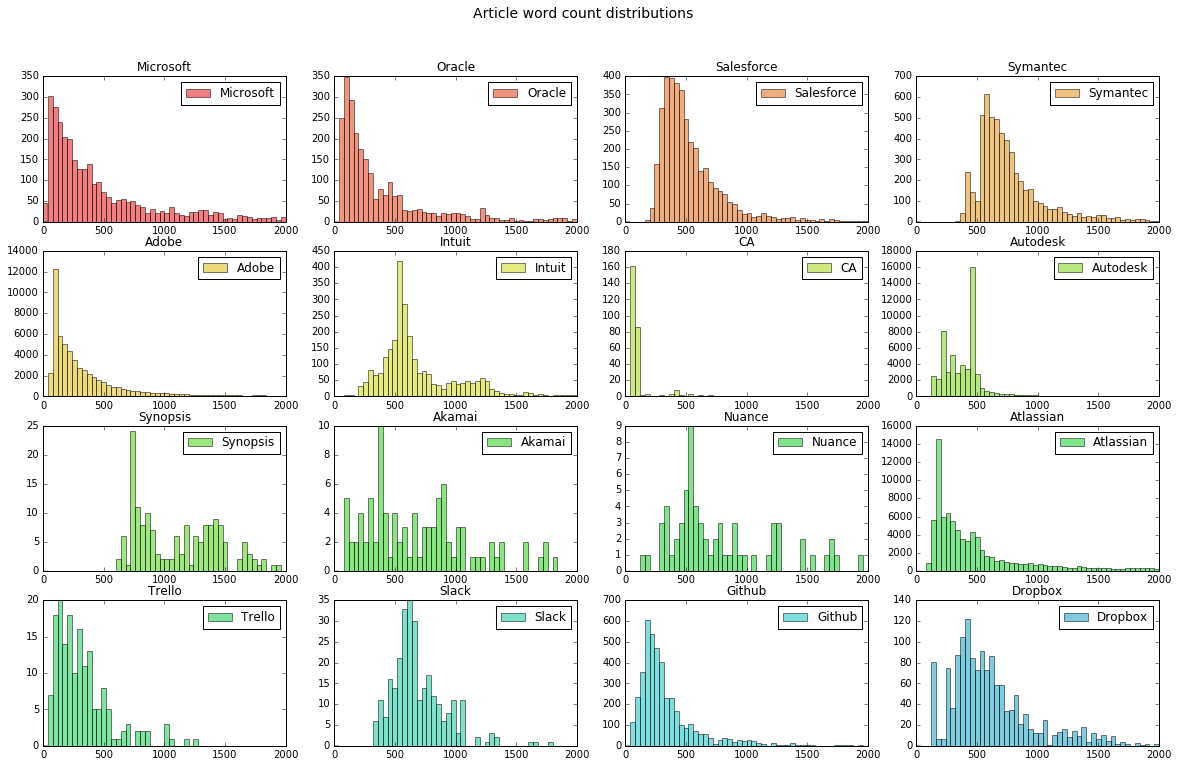

In [18]:
plt.figure(figsize=(20, 12))
plt.suptitle('Article word count distributions',  fontsize=14)
plt.subplot(441)
plt.hist(xtmp[0], bins, range=(0,2000), alpha=0.5, label='Microsoft', color=c[0])
plt.title('Microsoft')
plt.legend(loc='upper right')
plt.subplot(442)
plt.hist(xtmp[1], bins, range=(0,2000), alpha=0.5, label='Oracle',color=c[1])
plt.title('Oracle')
plt.legend(loc='upper right')
plt.subplot(443)
plt.hist(xtmp[2], bins, range=(0,2000), alpha=0.5, label='Salesforce',color=c[2])
plt.title('Salesforce')
plt.legend(loc='upper right')
plt.subplot(444)
plt.hist(xtmp[3], bins, range=(0,2000), alpha=0.5, label='Symantec',color=c[3])
plt.title('Symantec')
plt.legend(loc='upper right')
plt.subplot(445)
plt.hist(xtmp[4], bins, range=(0,2000), alpha=0.5, label='Adobe', color=c[4])
plt.title('Adobe')
plt.legend(loc='upper right')
plt.subplot(446)
plt.hist(xtmp[5], bins, range=(0,2000), alpha=0.5, label='Intuit',color=c[5])
plt.title('Intuit')
plt.legend(loc='upper right')
plt.subplot(447)
plt.hist(xtmp[6], bins, range=(0,2000), alpha=0.5, label='CA',color=c[6])
plt.title('CA')
plt.legend(loc='upper right')
plt.subplot(448)
plt.hist(xtmp[7], bins, range=(0,2000), alpha=0.5, label='Autodesk',color=c[7])
plt.title('Autodesk')
plt.legend(loc='upper right')
plt.subplot(449)
plt.hist(xtmp[8], bins, range=(0,2000), alpha=0.5, label='Synopsis',color=c[8])
plt.title('Synopsis')
plt.legend(loc='upper right')
plt.subplot(4,4,10)
plt.hist(xtmp[9], bins, range=(0,2000), alpha=0.5, label='Akamai',color=c[9])
plt.title('Akamai')
plt.legend(loc='upper right')
plt.subplot(4,4,11)
plt.hist(xtmp[10], bins, range=(0,2000), alpha=0.5, label='Nuance',color=c[10])
plt.title('Nuance')
plt.legend(loc='upper right')
plt.subplot(4,4,12)
plt.hist(xtmp[11], bins, range=(0,2000), alpha=0.5, label='Atlassian',color=c[10])
plt.title('Atlassian')
plt.legend(loc='upper right')
plt.subplot(4,4,13)
plt.hist(xtmp[12], bins, range=(0,2000), alpha=0.5, label='Trello',color=c[11])
plt.title('Trello')
plt.legend(loc='upper right')
plt.subplot(4,4,14)
plt.hist(xtmp[13], bins, range=(0,2000), alpha=0.5, label='Slack',color=c[13])
plt.title('Slack')
plt.legend(loc='upper right')
plt.subplot(4,4,15)
plt.hist(xtmp[14], bins, range=(0,2000), alpha=0.5, label='Github',color=c[14])
plt.title('Github')
plt.legend(loc='upper right')
plt.subplot(4,4,16)
plt.hist(xtmp[15], bins, range=(0,2000), alpha=0.5, label='Dropbox',color=c[15])
plt.title('Dropbox')
plt.legend(loc='upper right')
plt.savefig('graphs/ALL_ArticleLengthDistributions_01.png')
plt.show()

** b) Descriptive statistics of article word count**

In [19]:
statsdf = pd.DataFrame(index=['mean'])
max = len(smap_idx)
means = {}
variances = {}
skewnesss = {}
kurtosiss = {}
for s in range(0,max):
    tmp = {}
    tmp = smap_idx[s]
    sd = stats.describe(tmp['Word Count'])
    #print sd.mean, sd.variance
    means[s] = sd.mean
    variances[s] = sd.variance
    skewnesss[s] = sd.skewness
    kurtosiss[s] = sd.kurtosis

** c) Test distribution normalility/ pairwise**

In [20]:
# Pairwise test
#ks_2samp(x,y)

### 3. Regression tests

** a) Load company data add docs metrics**
- Number of articles = docpagecnt
- Total word count = savelen[n]
- Article word count, mean & variance = means, variances

In [21]:
comps = pd.read_csv('data/ent_softwarecompanies.csv')

In [22]:
r01 = comps[comps['Company']=='Microsoft']
r02 = comps[comps['Company']=='Oracle']
r03 = comps[comps['Company']=='Salesforce']
r04 = comps[comps['Company']=='Symantec']
r05 = comps[comps['Company']=='Adobe']
r06 = comps[comps['Company']=='Intuit']
r07 = comps[comps['Company']=='CA']
r08 = comps[comps['Company']=='Autodesk']
r09 = comps[comps['Company']=='Synopsis']
r10 = comps[comps['Company']=='Akamai']
r11 = comps[comps['Company']=='Nuance']
r12 = comps[comps['Company']=='Atlassian']
r13 = comps[comps['Company']=='Trello']
r14 = comps[comps['Company']=='Slack']
r15 = comps[comps['Company']=='Github']
r16 = comps[comps['Company']=='Dropbox']

In [23]:
df = pd.DataFrame()
cdf = []
cdf = df.append([r01,r02,r03,r04,r05,r06,r07,r08,r09,r10,r11,r12,r13,r14,r15,r16])
cdf.index = [[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]]

In [24]:
tc = pd.Series(gwc)
sl = pd.Series(savelen)
awc = pd.Series(means)
wcv = pd.Series(variances)
wcs = pd.Series(skewnesss)
wck = pd.Series(kurtosiss)

In [25]:
cdf['docs_total_pages']=sl
cdf['docs_total_words']=tc
cdf['docs_wordlen_mean']=awc
cdf['docs_wordlen_variance']=wcv
cdf['docs_wordlen_skewness']=wcs
cdf['docs_wordlen_kurtosis']=wck

In [26]:
ndf = pd.DataFrame(cdf)
droplist = ['Index','Company','shareticker','Website','Documentation','Type','ProductList']
ndf.drop(ndf[droplist],inplace=True,axis=1)

** b) Scatter plots**

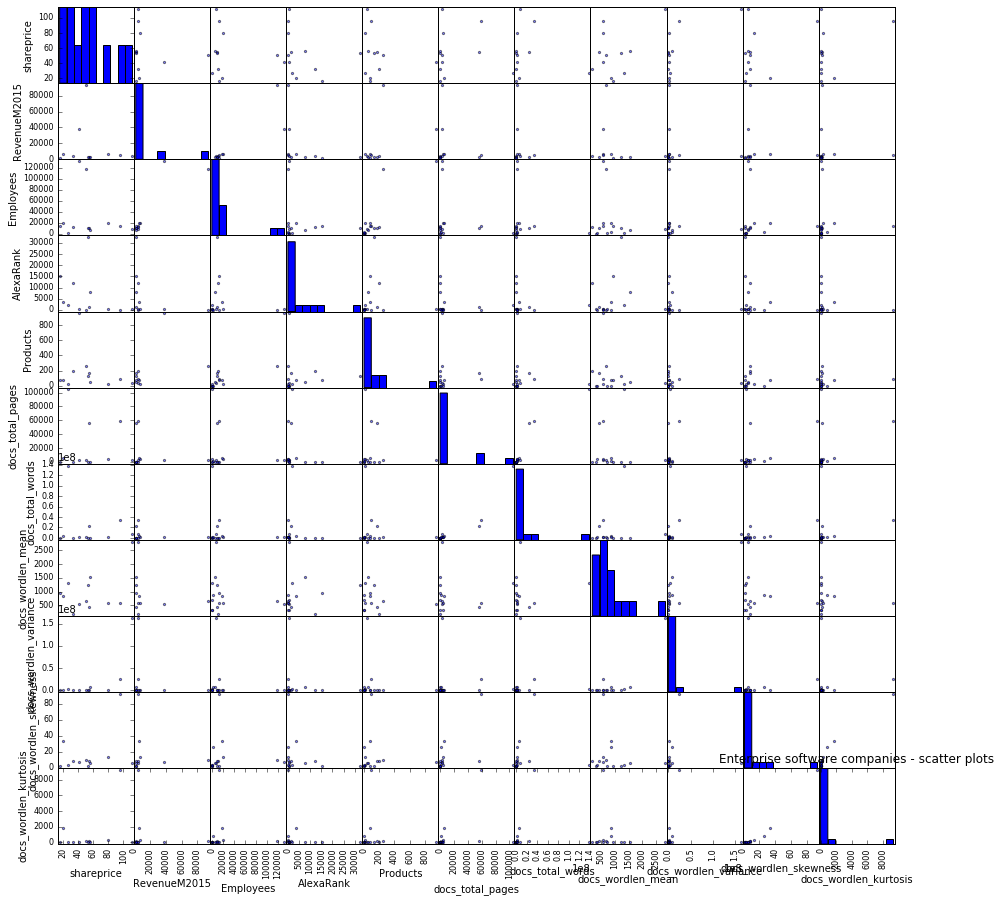

In [27]:
fig = pd.scatter_matrix(ndf, figsize=(15,15))
plt.title('Enterprise software companies - scatter plots')
plt.savefig('graphs/ALL_ScatterPlots_01.png')

** c) RANSAC regression analysis**

In [28]:
tmp = pd.DataFrame(ndf).dropna()
d1 = pd.DataFrame(tmp['AlexaRank'])
d2 = pd.DataFrame(tmp['shareprice'])

In [29]:
ransac = sklearn.linear_model.RANSACRegressor()

In [30]:
ransac.fit(d1,d2)

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        max_trials=100, min_samples=None, random_state=None,
        residual_metric=None, residual_threshold=None, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

In [31]:
predict = ransac.predict(d1)

** d) Graph regression: shareprice & web traffic**

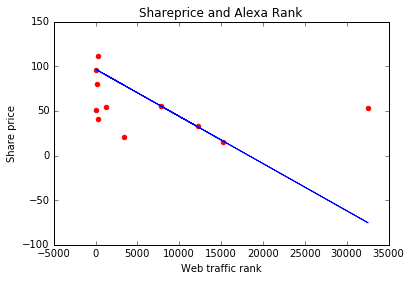

In [32]:
plt.scatter(d1,d2, color='red')
plt.plot(d1, predict, color='blue')
plt.xlabel('Web traffic rank')
plt.ylabel('Share price')
plt.title('Shareprice and Alexa Rank')
plt.savefig('graphs/ArticleLength_RANSAC_shareprice_alexarank_01.png')

** e) Graph regression: article length & web traffic**

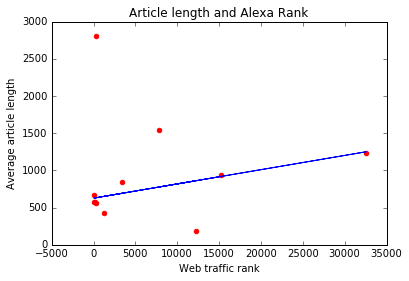

In [45]:
d1 = pd.DataFrame(tmp['AlexaRank'])
d2 = pd.DataFrame(tmp['docs_wordlen_mean'])
ransac = sklearn.linear_model.RANSACRegressor()
ransac.fit(d1,d2)
predict = ransac.predict(d1)
plt.scatter(d1,d2, color='red')
plt.plot(d1, predict, color='blue')
plt.xlabel('Web traffic rank')
plt.ylabel('Average article length')
plt.title('Article length and Alexa Rank')
plt.savefig('graphs/ArticleLength_RANSAC_wordlen_alexarank_01.png')

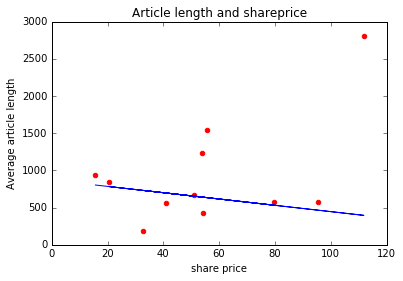

In [46]:
d1 = pd.DataFrame(tmp['shareprice'])
d2 = pd.DataFrame(tmp['docs_wordlen_mean'])
ransac = sklearn.linear_model.RANSACRegressor()
ransac.fit(d1,d2)
predict = ransac.predict(d1)
plt.scatter(d1,d2, color='red')
plt.plot(d1, predict, color='blue')
plt.xlabel('share price')
plt.ylabel('Average article length')
plt.title('Article length and shareprice')
plt.savefig('graphs/ArticleLength_RANSAC_wordlen_shareprice_01.png')

### 4. Cluster analysis
- Cluster analysis on article length mean and skew 

In [36]:
colsdiv = np.array(['#E50004','#DD8900','#9CD500','#12CE00','#00C66E','#0098BF','Blue'])
clustdf = pd.DataFrame(data = [ndf['docs_wordlen_mean'],ndf['docs_wordlen_skewness']])
cldf = pd.DataFrame.transpose(clustdf)

In [37]:
cl = sklearn.cluster.KMeans(init='k-means++', n_clusters=5)

In [38]:
x_clust = cl.fit_predict(cldf)
ccenters = cl.cluster_centers_

** a) Plot clusters in 2d (mean, skew)**

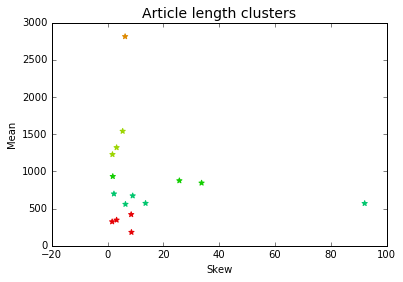

In [39]:
plt.title('Article length clusters',  fontsize=14)
plt.scatter( ndf['docs_wordlen_skewness'],ndf['docs_wordlen_mean'], color=colsdiv[x_clust], marker='*', s=30 )
plt.xlabel('Skew')
plt.ylabel('Mean')
plt.savefig('graphs/ArticleDistribution_clusters2dPlot.png')

** b) 3D cluster plot**

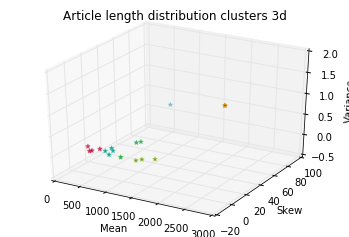

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d') 
ax.scatter(ndf['docs_wordlen_mean'],ndf['docs_wordlen_skewness'],ndf['docs_wordlen_variance'], color=colsdiv[x_clust], marker='*')
ax.set_xlabel('Mean')
ax.set_ylabel('Skew')
ax.set_zlabel('Variance')
plt.title('Article length distribution clusters 3d')
plt.savefig('graphs/ALL_ArticleLengthDist_KMeans_3dPlot.png')

** c) Article length distribution clusters**

In [41]:
cdf['KMeanGroup']=x_clust
t = pd.DataFrame(data=[cdf['KMeanGroup'],cdf['Company']])
tc = t.transpose() #<---- look at cluster groups
tc['Cols'] = cols

In [42]:
pc = tc['Cols']

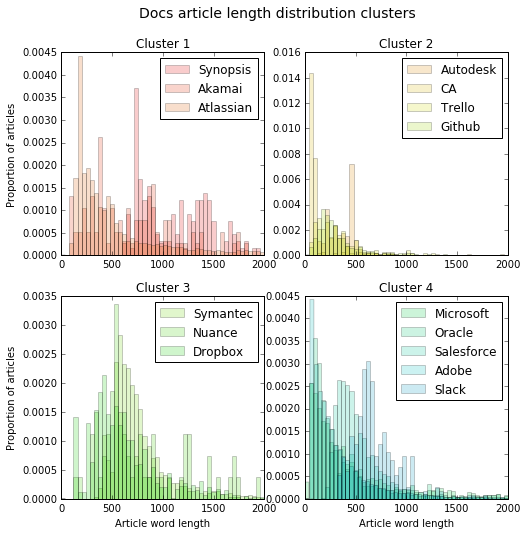

In [43]:
# Option #1: Scatter Plot Grid
plt.figure(figsize=(8, 8))
plt.suptitle('Docs article length distribution clusters',  fontsize=14)
# Upper Left
plt.subplot(221)
plt.hist(xtmp[8], bins, range=(0,2000), normed=True, alpha=0.2, label='Synopsis',color=pc[0])
plt.hist(xtmp[9], bins, range=(0,2000), normed=True, alpha=0.2, label='Akamai',color=pc[1])
plt.hist(xtmp[11], bins, range=(0,2000), normed=True, alpha=0.2, label='Atlassian',color=pc[2])
plt.title('Cluster 1')
plt.legend(loc='upper right')
plt.ylabel('Proportion of articles')

# Upper Right
plt.subplot(222)
plt.hist(xtmp[7], bins, range=(0,2000), normed=True, alpha=0.2, label='Autodesk',color=pc[3])
plt.hist(xtmp[6], bins, range=(0,2000), normed=True, alpha=0.2, label='CA',color=pc[4])
plt.hist(xtmp[12], bins, range=(0,2000), normed=True, alpha=0.2, label='Trello',color=pc[5])
plt.hist(xtmp[14], bins, range=(0,2000), normed=True, alpha=0.2, label='Github',color=pc[6])
plt.title('Cluster 2')
plt.legend(loc='upper right')
# Lower Left
plt.subplot(223)
plt.hist(xtmp[3], bins, range=(0,2000), normed=True, alpha=0.2, label='Symantec',color=pc[7])
plt.hist(xtmp[10], bins, range=(0,2000), normed=True, alpha=0.2, label='Nuance',color=pc[8])
plt.hist(xtmp[15], bins, range=(0,2000), normed=True, alpha=0.2, label='Dropbox',color=pc[9])
plt.title('Cluster 3')
plt.legend(loc='upper right')
plt.xlabel('Article word length')
plt.ylabel('Proportion of articles')
# Lower Right
plt.subplot(224)
plt.hist(xtmp[0], bins, range=(0,2000), normed=True, alpha=0.2, label='Microsoft', color=pc[11])
plt.hist(xtmp[1], bins, range=(0,2000), normed=True, alpha=0.2, label='Oracle',color=pc[12])
plt.hist(xtmp[2], bins, range=(0,2000), normed=True, alpha=0.2, label='Salesforce',color=pc[13])
plt.hist(xtmp[4], bins, range=(50,2000), normed=True, alpha=0.2, label='Adobe',color=pc[14])
plt.hist(xtmp[13], bins, range=(0,2000), normed=True, alpha=0.2, label='Slack',color=pc[15])
plt.title('Cluster 4')
plt.legend(loc='upper right')
plt.xlabel('Article word length')
plt.savefig('graphs/ALL_ArticleLengthDist_ClusterResults_01.png')
#plt.xlabel(iris.feature_names[3])

** d) Test number of clusters**

In [44]:
# not finished

### 5. Preliminary results


##### Regression analysis of Alexa web traffic rank for docs domain
1. Rank and shareprice = 
2. Rank and docs article length = 

##### KMeans for 6 clusters?
Need to test others

0. Atlassian, Akamai, Synopsis
1. Intuit
2. CA, Autodesk, Trello, Github
3. Symantec, Nuance, Dropbox
4. Microsoft, Oracle, Salesforce, Adobe, Slack